# Customer Segmentation using Clustering


### Context
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers for wine products. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an excel workbook containing two worksheets. Each worksheet contains a different dataset.

We will be using the data we segment the customers using clustering algorithm.

In [46]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")

In [52]:
df_offers = pd.read_excel("./datasets/WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [53]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   offer_id   32 non-null     int64 
 1   campaign   32 non-null     object
 2   varietal   32 non-null     object
 3   min_qty    32 non-null     int64 
 4   discount   32 non-null     int64 
 5   origin     32 non-null     object
 6   past_peak  32 non-null     bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 1.7+ KB


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [54]:
df_transactions = pd.read_excel("./datasets/WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [55]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  324 non-null    object
 1   offer_id       324 non-null    int64 
 2   n              324 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


### Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [56]:
# merging both the dataframes
df_merged= pd.merge(df_transactions, df_offers)
df_merged.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False
2,Martin,2,1,January,Pinot Noir,72,17,France,False
3,Jackson,2,1,January,Pinot Noir,72,17,France,False
4,Campbell,2,1,January,Pinot Noir,72,17,France,False


In [57]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  324 non-null    object
 1   offer_id       324 non-null    int64 
 2   n              324 non-null    int64 
 3   campaign       324 non-null    object
 4   varietal       324 non-null    object
 5   min_qty        324 non-null    int64 
 6   discount       324 non-null    int64 
 7   origin         324 non-null    object
 8   past_peak      324 non-null    bool  
dtypes: bool(1), int64(4), object(4)
memory usage: 23.1+ KB


In [58]:
matrix = df_merged.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [59]:
matrix = matrix.fillna(0).reset_index()
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_name  100 non-null    object 
 1   1              100 non-null    float64
 2   2              100 non-null    float64
 3   3              100 non-null    float64
 4   4              100 non-null    float64
 5   5              100 non-null    float64
 6   6              100 non-null    float64
 7   7              100 non-null    float64
 8   8              100 non-null    float64
 9   9              100 non-null    float64
 10  10             100 non-null    float64
 11  11             100 non-null    float64
 12  12             100 non-null    float64
 13  13             100 non-null    float64
 14  14             100 non-null    float64
 15  15             100 non-null    float64
 16  16             100 non-null    float64
 17  17             100 non-null    float64
 18  18         

In [61]:
cust_offers = matrix.sum(axis=1)
print(cust_offers.max(), cust_offers.min()) 

9.0 1.0


In [62]:
offers_count = matrix.iloc[:,1:].sum(axis=0)
offers_count.sort_values(ascending = False)

offer_id
30    22.0
22    21.0
8     20.0
7     19.0
29    17.0
31    17.0
26    15.0
18    14.0
11    13.0
4     12.0
6     12.0
24    12.0
9     10.0
1     10.0
2     10.0
14     9.0
27     9.0
17     7.0
10     7.0
3      6.0
15     6.0
13     6.0
25     6.0
28     6.0
20     6.0
16     5.0
12     5.0
19     5.0
23     5.0
5      4.0
21     4.0
32     4.0
dtype: float64

### K-Means Clustering

Using K-Means Clustering, where we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. 

We are using these methods: the Elbow method, the Silhouette method and the gap statistic, for choosing the correct value of `k` for clustering.

#### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares (SS) error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

The lower the values of SS the better the clustering, as there is a shorter distance between the centroid and all the points belonging to the cluster.

In [63]:
x_cols = matrix[matrix.columns[1:]]
x_cols.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
#KMeans
from sklearn.cluster import KMeans

In [65]:
model = KMeans()
model.fit(x_cols)

KMeans()

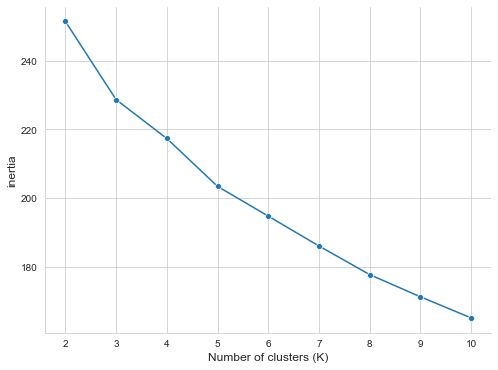

In [71]:
# KMeans has an attribute inertia that gives the sum of squared distances of samples to their closest cluster center.

# constructing a lineplot to determine the best K (number_of_clusters)
number_of_clusters = np.arange(2, 11)
inertia = []

# iterating over the possible K, with a random generator seed of 10 for reproducibility.
for i in number_of_clusters:
    model = KMeans(n_clusters=i, random_state=10)
    model.fit(x_cols)
    inertia.append(model.inertia_)

# plot
plt.figure(figsize = (8,6))
sns.lineplot(number_of_clusters, inertia, marker='o')
sns.despine()
plt.xlabel("Number of clusters (K)", fontsize = 12)
plt.ylabel("inertia", fontsize = 12)
plt.xticks(number_of_clusters)
plt.show()

There is not a clear "elbow" when plotting the SS against the number of clusters in the model.

We will choose k = 5 i.e. 5 clusters.

In [67]:
# Make a bar chart showing the number of points in each cluster for k-means under the best 𝐾 .

k = 5
model = KMeans(n_clusters=k, random_state=10)

matrix['cluster'] = model.fit_predict(x_cols)

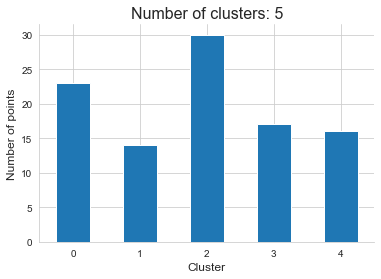

In [73]:
# barplot
plt.figure(figsize = (6,4))
matrix['cluster'].value_counts(sort = False).plot(kind='bar') 
sns.despine()
plt.title("Number of clusters: {}".format(k), fontsize = 16)
plt.xlabel("Cluster", fontsize = 12)
plt.ylabel("Number of points", fontsize = 12)
plt.xticks(rotation=0)
plt.show()

#### Choosing K: The Silhouette Method

There is an another method to choose the value of k - Silhouette method. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
For n_clusters = 10 The average silhouette_score is : 0.12819851045484193


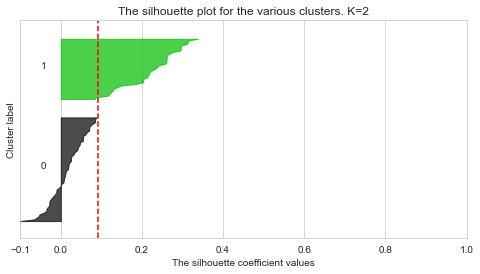

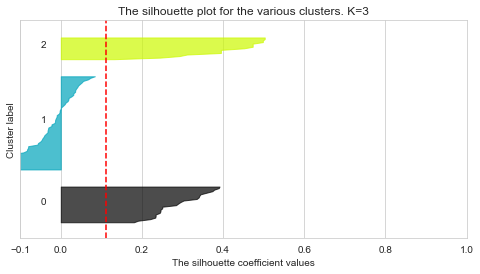

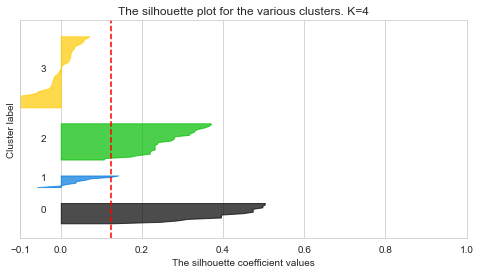

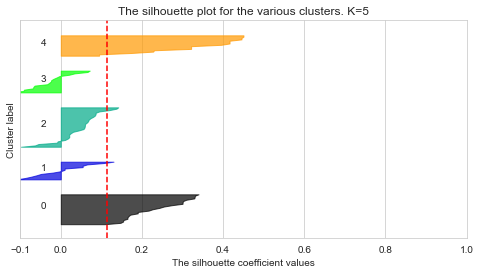

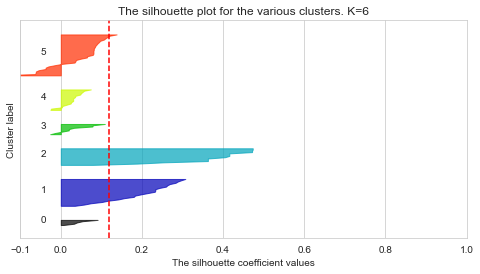

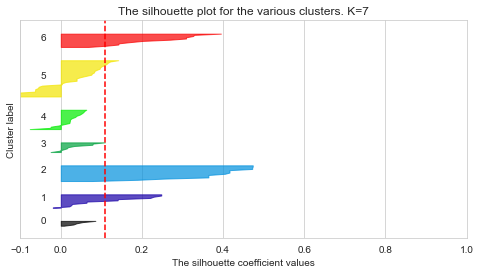

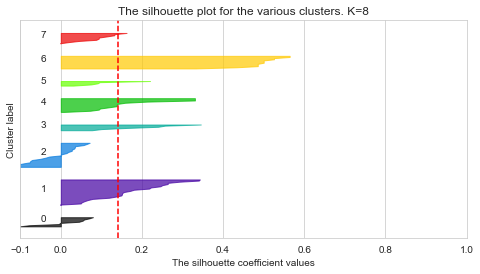

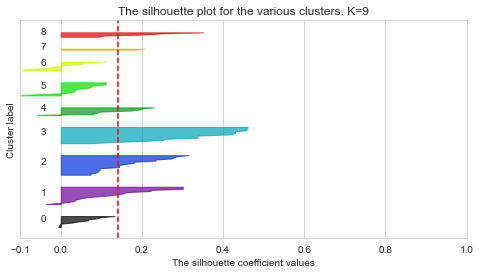

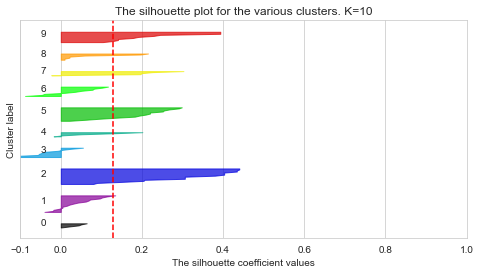

In [74]:
from sklearn.metrics import silhouette_score ,silhouette_samples
import matplotlib.cm as cm

# range of the number of clusters previously defined
number_of_clusters

score = {}
# iterate
for n_clusters in number_of_clusters:
    # Create a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    score[n_clusters] = round(silhouette_avg, 4)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters. K={}".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [22]:
best = max(score, key=score.get)
print('The best value of k is {} with the highest average silhouette score of {}'.format(best, score[best]))

The best value of k is 9 with the highest average silhouette score of 0.1418


The plots suggest that K=5 is a good choice. It has the highest average silhouette score. 

However, there is still some ambiguity. K=6 would have been a good choice too, as the cluster size is more similar among the data (represented by the thickness of the silhouette plot). The ambguity between k = 5 and 6 is not clear.

#### Choosing $K$: The Gap Statistic

There is one last method to check for picking $K$, the so-called Gap statistic.

### Visualizing Clusters using PCA

We will first use dimensionality reduction technique to reduce to the dimensionality of out data. We will be using Principal Component Analysis (PCA) for dimensionality reduction. For a visualization on the coordinate plane, we will use 2 dimensions.

In [23]:
x_cols.shape

(100, 32)

In [24]:
from sklearn.decomposition import PCA

# PCA model with 2 components
pca = PCA(n_components=2)

# fit
pca.fit(x_cols)

# features
pca_features = pca.transform(x_cols)

pca_features.shape

(100, 2)

In [25]:
K = 5

# model: KMeans
model = KMeans(n_clusters=K, random_state=10)

# fit_predict
cluster_id = model.fit_predict(x_cols)

# PCA components
x = pca_features[:, 0]
y = pca_features[:, 1]

# new dataframe
new_df = pd.DataFrame({'customer_name': matrix.customer_name, 'cluster_id': cluster_id, 'x': x, 'y': y})

new_df.head()

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,4,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,2,0.088183,-0.471695


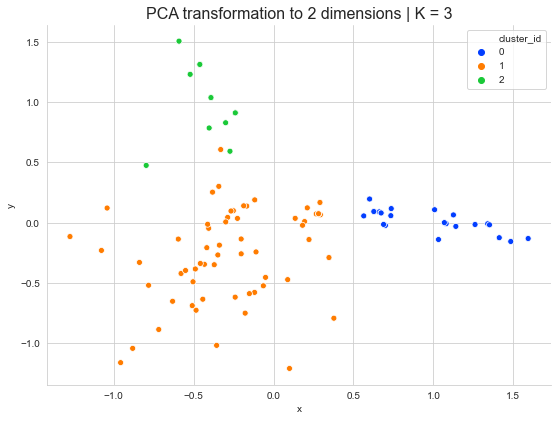

In [78]:
# scatterplot
plt.figure(figsize = (7,5))
palette = sns.color_palette("bright", K)
sns.scatterplot(x='x', y='y', data=new_df, hue='cluster_id', palette=palette)

# formatting
plt.title("PCA transformation to 2 dimensions | K = {}".format(K), fontsize = 16)
plt.legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
sns.despine()
plt.show()

**How do the clusters look?**

There is some differentiation, but in the center there is some overlapping. The green and the blue cluster differentiate from the others, while the others not. (with K=5)


Maybe K=3 would be the best. It would join the red, violet and orange clusters (3, 4 and 1). Both methods pointed initially to K=5, and both were ambiguous, but probably the Elbow method pointed (me) more to this renewed direction of choosing K=3.

In [27]:
K = 3

# model: KMeans
model = KMeans(n_clusters=K, random_state=10)

# fit_predict
cluster_id = model.fit_predict(x_cols)

# PCA components
x = pca_features[:, 0]
y = pca_features[:, 1]

# new dataframe
new_df = pd.DataFrame({'customer_name': matrix.customer_name, 'cluster_id': cluster_id, 'x': x, 'y': y})

new_df.head()

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


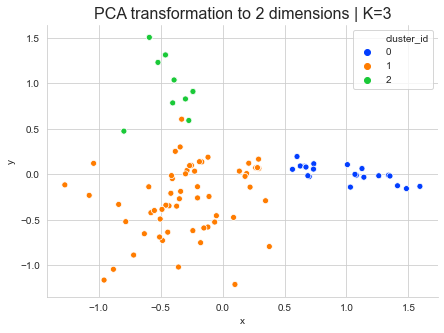

In [79]:
# scatterplot
plt.figure(figsize = (7,5))
palette = sns.color_palette("bright", K)
sns.scatterplot(x='x', y='y', data=new_df, hue='cluster_id', palette=palette)
sns.despine()
# formatting
plt.title("PCA transformation to 2 dimensions | K={}".format(K), fontsize = 16)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

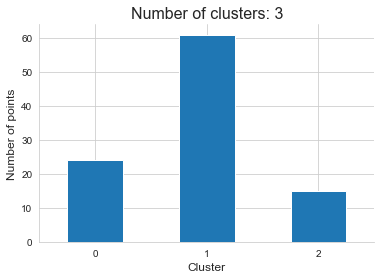

In [81]:
k = 3
plt.figure(figsize = (6,4))
model = KMeans(n_clusters=k, random_state=10)

# fit the model to the data, x_cols
matrix['cluster_3'] = model.fit_predict(x_cols)

# barplot
matrix['cluster_3'].value_counts(sort = False).plot(kind='bar') 
plt.title("Number of clusters: {}".format(k), fontsize = 16)
plt.xlabel("Cluster", fontsize = 12)
plt.ylabel("Number of points", fontsize = 12)
sns.despine()
plt.xticks(rotation=0)
plt.show()

In [30]:
# merging the raw data with the given clusters
raw_clust = pd.merge(new_df, df_merged, how='outer').drop(['x', 'y', 'n'], axis=1)

raw_clust.head()

,customer_name,cluster_id,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,Adams,0,18,July,Espumante,6,50,Oregon,False
1,Adams,0,29,November,Pinot Grigio,6,87,France,False
2,Adams,0,30,December,Malbec,6,54,France,False
3,Allen,1,9,April,Chardonnay,144,57,Chile,False
4,Allen,1,27,October,Champagne,72,88,New Zealand,False


In [31]:
raw_clust['campaign'].unique()

array(['July', 'November', 'December', 'April', 'October', 'September',
       'March', 'August', 'January', 'May', 'February', 'June'],
      dtype=object)

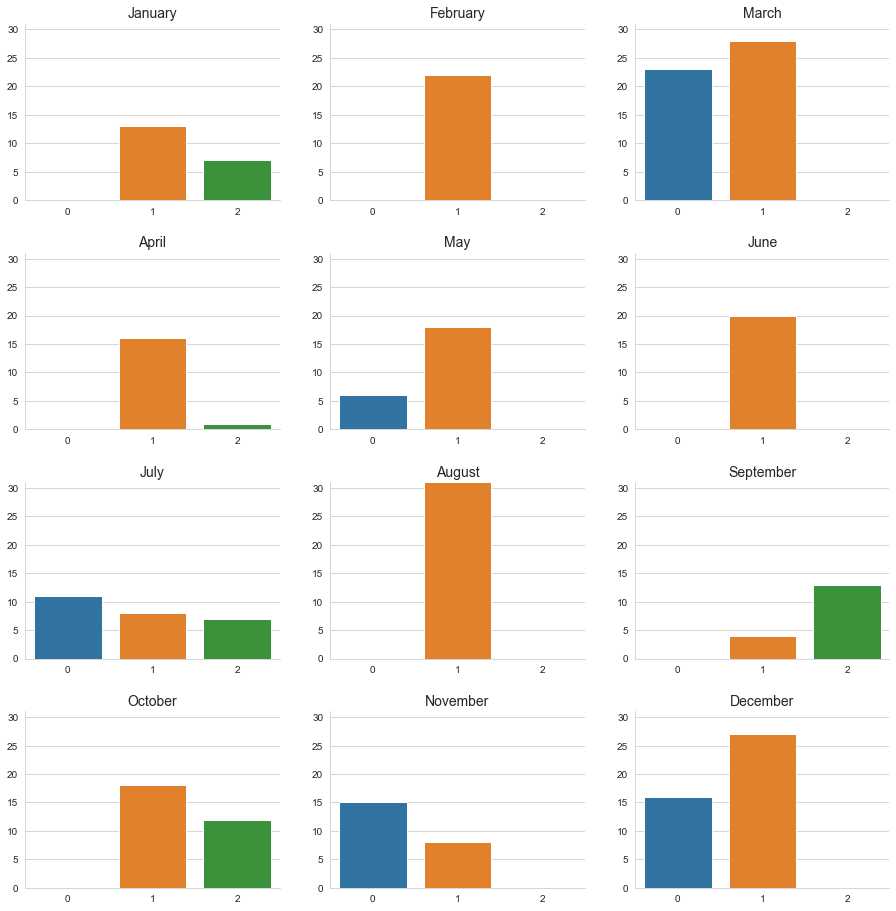

In [83]:
# Variable
variable = 'campaign'

# labels
clusters = np.arange(k)

# options
import calendar
options = list(calendar.month_name)[1:]

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(4, 3, i+1)
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title(options[i], fontsize = 14)
    
plt.subplots_adjust(left=0, bottom=-2, right=2, top=1, wspace=0.2, hspace=0.3)
sns.despine()
plt.show()

In [33]:
raw_clust['varietal'].unique()

array(['Espumante', 'Pinot Grigio', 'Malbec', 'Chardonnay', 'Champagne',
       'Pinot Noir', 'Prosecco', 'Cabernet Sauvignon', 'Merlot'],
      dtype=object)

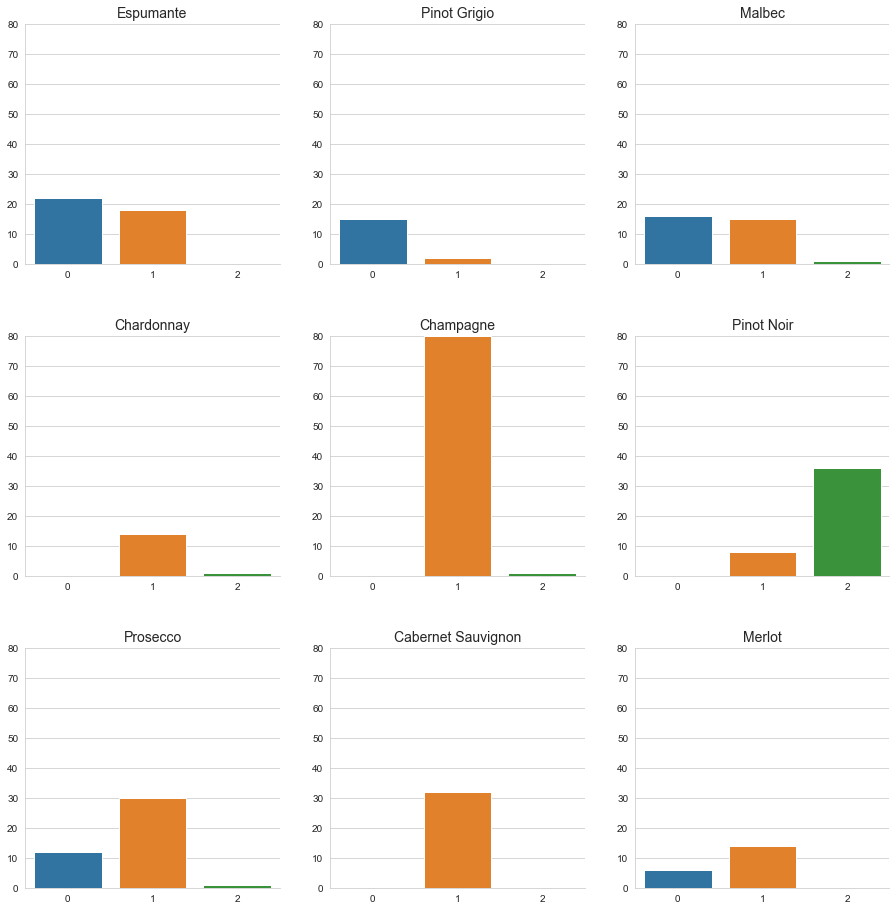

In [84]:
# Variable
variable = 'varietal'

# labels
clusters = np.arange(K)

# options
options = raw_clust[variable].unique()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(3, 3, i+1)
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title(options[i], fontsize = 14)

sns.despine()
plt.subplots_adjust(left=0, bottom=-2, right=2, top=1, wspace=0.2, hspace=0.3)
plt.show()

In [35]:
raw_clust.min_qty.unique()

array([  6, 144,  72,  12], dtype=int64)

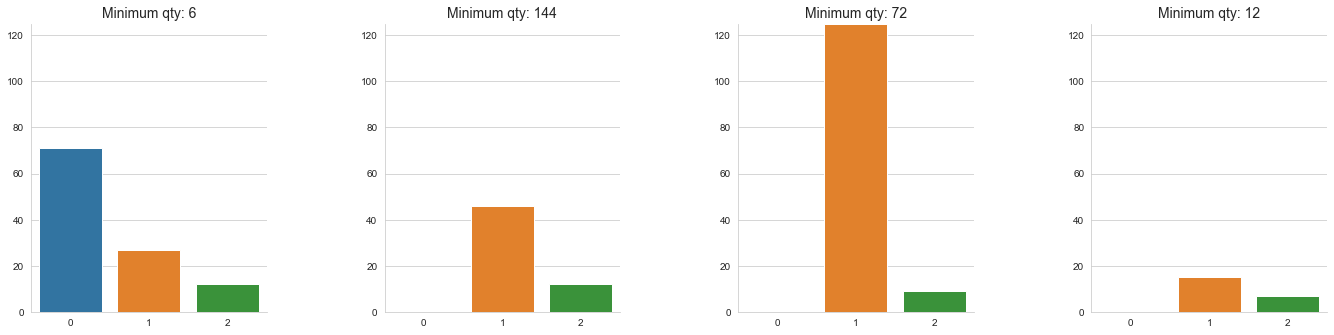

In [85]:
# Variable
variable = 'min_qty'

# labels
clusters = np.arange(K)

# options
options = raw_clust[variable].unique()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(1, 4, i+1) 
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title("Minimum qty: {}".format(options[i]),  fontsize = 14)

sns.despine()
plt.subplots_adjust(left=0, bottom=0, right=3, top=1, wspace=0.5, hspace=0.3)
plt.show()

In [37]:
raw_clust.discount.sort_values().unique()

array([17, 19, 32, 34, 39, 40, 43, 44, 45, 47, 48, 50, 52, 54, 56, 57, 59,
       63, 64, 66, 82, 83, 85, 86, 87, 88, 89], dtype=int64)

Number of different discounts: 27
Low:  [17 19 32 34 39 40 43 44 45]
Medium:  [47 48 50 52 54 56 57 59 63]
High:  [64 66 82 83 85 86 87 88 89]


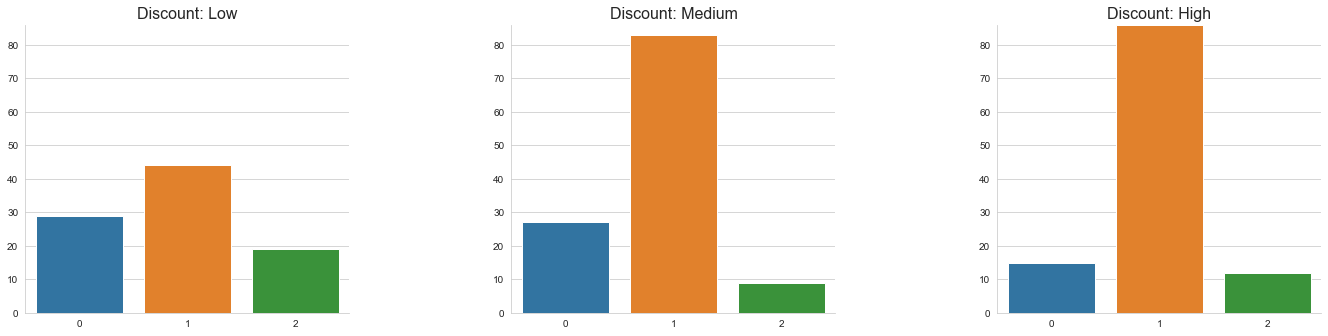

In [87]:
# Variable
variable = 'discount'

# subdivide into 3 intervals with 9 values each: low, medium, high
discounts = raw_clust.discount.sort_values().unique()

print("Number of different discounts:", len(discounts)) 

low = discounts[:9]
medium = discounts[9:18]
high = discounts[18:]

print("Low: ", low)
print("Medium: ", medium)
print("High: ", high)

# labels
clusters = np.arange(K)

# options
options = discounts.copy()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

new_matrix = np.array([[np.sum(matrix[0][:9]), np.sum(matrix[0][9:18]), np.sum(matrix[0][18:])], 
                       [np.sum(matrix[1][:9]), np.sum(matrix[1][9:18]), np.sum(matrix[1][18:])], 
                       [np.sum(matrix[2][:9]), np.sum(matrix[2][9:18]), np.sum(matrix[2][18:])]])

# plot
titles = ["Low", "Medium", "High"]

for i in range(len(new_matrix)):
    plt.subplot(1, 3, i+1) 
    sizes = new_matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(new_matrix))
    plt.title("Discount: {}".format(titles[i]), fontsize = 16)

sns.despine()
plt.subplots_adjust(left=0, bottom=0, right=3, top=1, wspace=0.5, hspace=0.3)
plt.show()

In [39]:
raw_clust.origin.unique()

array(['Oregon', 'France', 'Chile', 'New Zealand', 'Italy', 'Australia',
       'California', 'Germany', 'South Africa'], dtype=object)

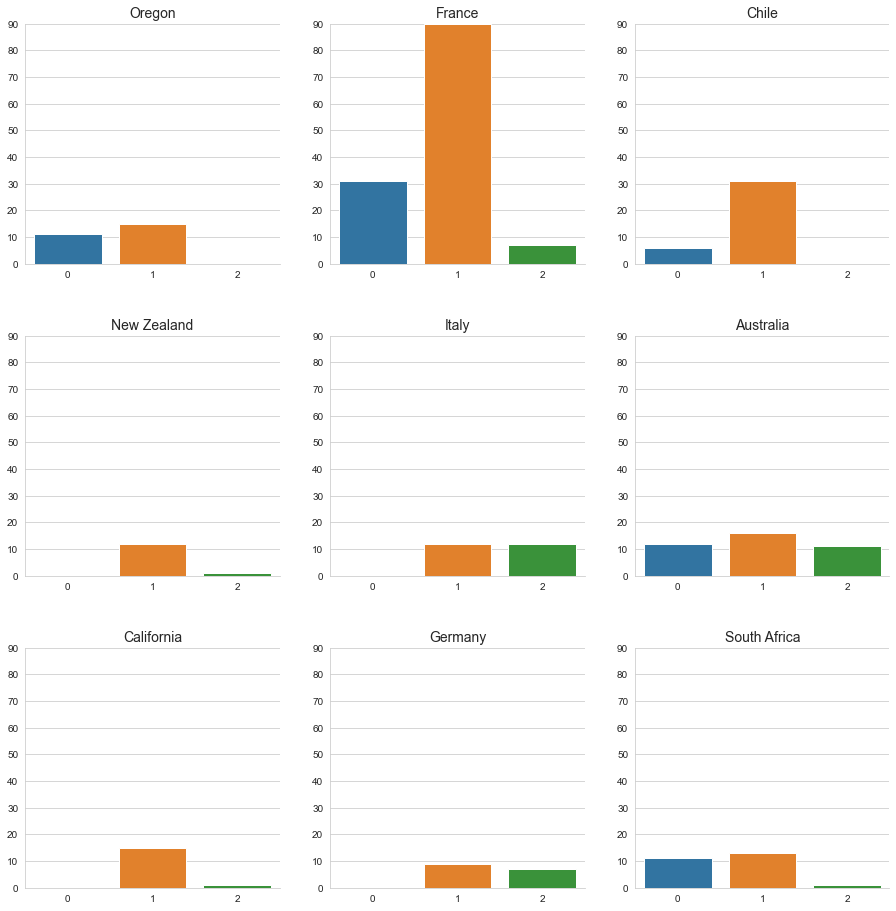

In [88]:
# Variable
variable = 'origin'

# labels
clusters = np.arange(K)

# options
options = raw_clust[variable].unique()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(3, 3, i+1)
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title(options[i], fontsize = 14)

sns.despine()
plt.subplots_adjust(left=0, bottom=-2, right=2, top=1, wspace=0.2, hspace=0.3)
plt.show()

Cluster 0:
* The cluster with the highest number of customers (more than 40). 
* The customers have approximately equal expenditure in all the months, no specific month to highlight.
* The customers has highest liking to 'Champagne' varietal.
* The customers have at east minimum of 72 of coupons.
* The customers prefer high or medium discounts.
* The customers like wine majorly of France origin.

Cluster 1:
* The second highest cluster with 35 customers.
* The customers are more involved in the monthe of March and least involved in January, June & September.
* The customers like 'Espumante' varietal and does not like 'Chardonnay', 'Pinot Noir' & 'Cabernet Sauvignon' varietal.
* The customers have minimum 6 coupons seldomly more than that.
* The customers like all kinds of discount - Low, Medium, High.
* The customers like wine from France, Oregon, Australia & South Africa origin, they do not like wine from New Zealand, Italy, California, Germany.

Cluster 2:
* The smallest cluster with 15 customers.
* The customers does not use coupons from February, March, April, May, June, August, November and December. 
* The customers only like Pinot Noir varietal and none of the others.
* The customers like wine from France, Italy, Australia and Germany origin.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

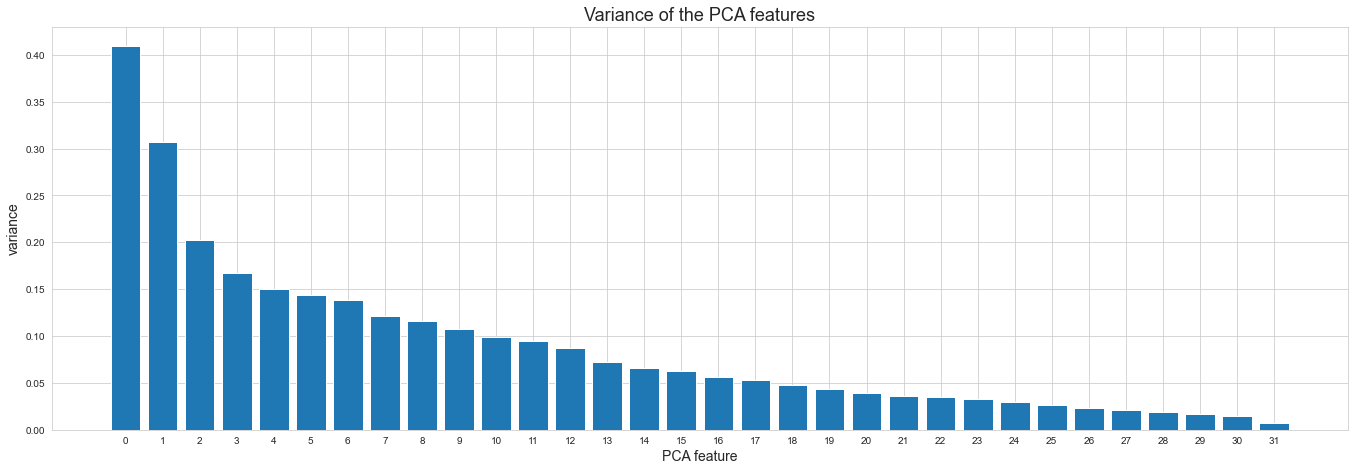

In [90]:
X = x_cols.copy()

# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_)

# formatting
plt.title("Variance of the PCA features", fontsize = 18)
plt.xlabel('PCA feature', fontsize = 14)
plt.ylabel('variance',fontsize = 14)
plt.xticks(features)

plt.subplots_adjust(left=0, bottom=-0.4, right=3, top=1, wspace=0, hspace=0)
plt.show()

Three seems to be the elblow point as the curve's rate of descent seems to slow sharply.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>

Source: http://scikit-learn.org/stable/modules/clustering.html